# 2. Optimisation demostration 

This notebook demostrates optimisation functionality. It covers:

2.1 Optimization Problem Setup
- Understand objective functions and constraints
- Configure optimization parameters

2.2 Single Optimization Run
- Configure PSO algorithm
- Run optimization with monitoring
- Analyze results and constraint violations

2.3 Multi-Run Analysis
- Statistical robustness testing
- Algorithm parameter sensitivity
- Convergence analysis

2.4 Advanced Scenarios
- Multiple constraint types
- Different objective functions
- Parameter tuning strategies



In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from typing import Dict, Any
import logging

# Add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("=== TRANSIT OPTIMIZATION SETUP ===")
print("🚀 Starting self-contained optimization workflow")
print("📊 This notebook will prepare data from scratch and run PSO optimization")


=== TRANSIT OPTIMIZATION SETUP ===
🚀 Starting self-contained optimization workflow
📊 This notebook will prepare data from scratch and run PSO optimization


"""
## 2.1 Data Preparation and Problem Setup

### GTFS Data Loading

First, we'll load the GTFS feed and transform it into optimization data structure.
This replicates the key steps from notebook 1 but focuses only on what's needed for optimization.


In [2]:
from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator

print("=== LOADING GTFS DATA ===")

# Create GTFS preparator with same settings as notebook 1
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=6,  # 4 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes=240.0,  # Maximum round-trip time
    no_service_threshold_minutes=480.0,  # Threshold for no-service mapping
    log_level="INFO"  # Less verbose than notebook 1
)

# Define allowed headways for optimization
allowed_headways = [10, 15, 30, 60, 120, 240] # in minutes

print(f"📋 Allowed headways: {allowed_headways} minutes")
print("🔄 Extracting optimization data...")

# Extract optimization data structure
opt_data = preparator.extract_optimization_data(allowed_headways)

print(f"\n✅ GTFS DATA PROCESSED:")
print(f"   📊 Routes: {opt_data['n_routes']}")
print(f"   ⏰ Time intervals: {opt_data['n_intervals']} (3h each)")
print(f"   🎯 Decision variables: {opt_data['decision_matrix_shape'][0]} × {opt_data['decision_matrix_shape'][1]} = {np.prod(opt_data['decision_matrix_shape'])}")
print(f"   🚗 Current peak fleet: {opt_data['constraints']['fleet_analysis']['total_current_fleet_peak']} vehicles")
print(f"   🔢 Headway choices: {opt_data['n_choices']} (including no-service)")


2025-09-05 15:29:35,119 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 6h intervals
2025-09-05 15:29:35,120 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip


=== LOADING GTFS DATA ===


2025-09-05 15:29:38,011 - transit_opt.preprocessing.prepare_gtfs - INFO - Using full GTFS feed (all service periods)
2025-09-05 15:29:40,032 - transit_opt.preprocessing.prepare_gtfs - INFO - GTFS loaded and cached in 4.91 seconds
2025-09-05 15:29:40,032 - transit_opt.preprocessing.prepare_gtfs - INFO - Dataset: 13,974 trips, 703,721 stop times
2025-09-05 15:29:40,033 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting optimization data with 6 allowed headways
2025-09-05 15:29:40,033 - transit_opt.preprocessing.prepare_gtfs - INFO - Extracting route essentials with 6-hour intervals


📋 Allowed headways: [10, 15, 30, 60, 120, 240] minutes
🔄 Extracting optimization data...


2025-09-05 15:29:44,393 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 4075: Round-trip 317.4min exceeds limit (240.0min), filtered out
2025-09-05 15:29:44,429 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 4122: Round-trip 366.8min exceeds limit (240.0min), filtered out
2025-09-05 15:29:46,308 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 3985: Round-trip 409.4min exceeds limit (240.0min), filtered out
2025-09-05 15:29:46,422 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 5496: Round-trip 416.3min exceeds limit (240.0min), filtered out
2025-09-05 15:29:46,537 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 3986: Round-trip 396.7min exceeds limit (240.0min), filtered out
2025-09-05 15:29:47,456 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 6790: Round-trip 396.7min exceeds limit (240.0min), filtered out
2025-09-05 15:29:48,968 - transit_opt.preprocessing.prepare_gtfs - WARNING - Service 3228: Round-tri


✅ GTFS DATA PROCESSED:
   📊 Routes: 141
   ⏰ Time intervals: 4 (3h each)
   🎯 Decision variables: 141 × 4 = 564
   🚗 Current peak fleet: 867 vehicles
   🔢 Headway choices: 7 (including no-service)



### Spatial Boundary Setup

Load the study area boundary for spatial filtering and analysis.
This ensures optimization focuses on the relevant geographic area.


In [3]:
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

print("\n=== SPATIAL BOUNDARY SETUP ===")

# Load boundary geometry
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
print(f"📍 Loaded boundary with {len(boundary_gdf)} feature(s)")

# Create study area boundary with buffer
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Web Mercator for spatial analysis
    buffer_km=2.0     # 2km buffer around boundary
)

print(f"✅ Study area boundary created:")
print(f"   📐 CRS: {study_boundary.target_crs}")
print(f"   📏 Buffer: 2km")


=== SPATIAL BOUNDARY SETUP ===
📍 Loaded boundary with 2607 feature(s)
✅ Validated metric CRS: EPSG:3857
🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857
📏 Applied 2.0km buffer
✅ Study area set: 1 polygon(s) in EPSG:3857
✅ Study area boundary created:
   📐 CRS: EPSG:3857
   📏 Buffer: 2km


### Optimization Problem Structure

Before diving into objectives and constraints, let's understand the mathematical structure
of our transit optimization problem.

In [4]:
print("\n=== OPTIMIZATION PROBLEM STRUCTURE ===")
print("🔢 DECISION VARIABLES:")
print(f"   • Each route-interval combination = 1 optimization variable")
print(f"   • Matrix structure: {opt_data['decision_matrix_shape']} (routes × intervals)")
print(f"   • Total variables: {opt_data['decision_matrix_shape'][0] * opt_data['decision_matrix_shape'][1]}")
print(f"   • Each variable chooses from {opt_data['n_choices']} discrete headway options")

print(f"\n🎯 DISCRETE CHOICES:")
print(f"   • Continuous headways (e.g., 17.3 minutes) → Discrete choices (e.g., 15 minutes)")
print(f"   • Algorithms choose indices (0-{opt_data['n_choices']-1}) representing allowed headways")
print(f"   • Variable bounds: {opt_data['variable_bounds']} (choice indices)")

print("\n🕐 ALLOWED HEADWAYS:")
for i, headway in enumerate(opt_data['allowed_headways']):
    if headway >= 9000:
        print(f"   Index {i}: No Service ({headway})")
    else:
        print(f"   Index {i}: {headway:.0f} minutes")

print("\n⏰ TIME STRUCTURE:")
for i, (label, hours) in enumerate(zip(opt_data['intervals']['labels'], opt_data['intervals']['hours'])):
    print(f"   Interval {i}: {label} ({hours[0]:02d}:00-{hours[1]:02d}:00)")



=== OPTIMIZATION PROBLEM STRUCTURE ===
🔢 DECISION VARIABLES:
   • Each route-interval combination = 1 optimization variable
   • Matrix structure: (141, 4) (routes × intervals)
   • Total variables: 564
   • Each variable chooses from 7 discrete headway options

🎯 DISCRETE CHOICES:
   • Continuous headways (e.g., 17.3 minutes) → Discrete choices (e.g., 15 minutes)
   • Algorithms choose indices (0-6) representing allowed headways
   • Variable bounds: (0, 6) (choice indices)

🕐 ALLOWED HEADWAYS:
   Index 0: 10 minutes
   Index 1: 15 minutes
   Index 2: 30 minutes
   Index 3: 60 minutes
   Index 4: 120 minutes
   Index 5: 240 minutes
   Index 6: No Service (9999.0)

⏰ TIME STRUCTURE:
   Interval 0: 00-06h (00:00-06:00)
   Interval 1: 06-12h (06:00-12:00)
   Interval 2: 12-18h (12:00-18:00)
   Interval 3: 18-24h (18:00-24:00)


### Objective Functions

Transit optimization typically involves competing objectives:

We'll focus on **Service Coverage** using spatial analysis. TODO: More complex objectives will be added later.

In [5]:
from transit_opt.optimisation.objectives import HexagonalCoverageObjective

print("\n=== OBJECTIVE FUNCTION: SERVICE COVERAGE ===")
print("Hexagonal Coverage Objective measures spatial equity by:")
print("• Dividing study area into hexagonal zones")
print("• Calculating vehicle service per zone based on headways")
print("• Minimizing variance in service distribution")
print("• Lower variance = more equitable service coverage")

# Create coverage objective with boundary filtering
coverage_objective = HexagonalCoverageObjective(
    optimization_data=opt_data,
    spatial_resolution_km=3.0,
    crs="EPSG:3857",
    boundary=study_boundary,  # This filters spatial analysis to study area
    spatial_lag=True,
    alpha=0.2
)

print(f"\n📍 Spatial System Created:")
print(f"   🔸 Hexagonal zones: {len(coverage_objective.spatial_system.hex_grid)}")
print(f"   🚏 Transit stops (filtered): {len(coverage_objective.spatial_system.stops_gdf)}")
print(f"   📐 Zone size: ~{3.0} km diameter hexagons")

# Evaluate current service coverage
current_objective_value = coverage_objective.evaluate(opt_data['initial_solution'])
print(f"\n🎯 CURRENT SERVICE COVERAGE:")
print(f"   Objective value (variance): {current_objective_value:.4f}")
print(f"   Lower values = more equitable coverage")

# Get detailed analysis of current coverage
current_analysis = coverage_objective.get_detailed_analysis(opt_data['initial_solution'])
print(f"   Zones with service: {current_analysis['zones_with_service_average']}")
print(f"   Mean vehicles per zone: {current_analysis['total_vehicles_average']:.1f}")
print(f"   Coefficient of variation: {current_analysis['coefficient_of_variation_average']:.3f}")



=== OBJECTIVE FUNCTION: SERVICE COVERAGE ===
Hexagonal Coverage Objective measures spatial equity by:
• Dividing study area into hexagonal zones
• Calculating vehicle service per zone based on headways
• Minimizing variance in service distribution
• Lower variance = more equitable service coverage
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6949 stops to EPSG:3857
🎯 Applying boundary filter to 6949 stops...
🔍 Filtered 6949 → 4419 points
✅ Filtered to 4419 stops within boundary
🔧 Creating 18 × 18 = 324 grid cells
   Grid bounds: (-195846, 7111259) to (-142157, 7162476) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 324 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 324 grid cells...
🔍 Filtered 324 → 251 grid cells
✅ Filtered to 251 grid cells within boundary
🚀 Using spatial join for zone mapping...
✅ Mapped 4419 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 278 routes/services
✅ Spatial system ready: 251 hexagonal zones,

### Constraint Types

Optimization constraints ensure solutions are operationally feasible:

1. **Fleet Total Constraint**: Limits peak vehicle requirements
2. **Fleet Per-Interval**: Limits vehicles needed in each time period  
3. **Minimum Service**: Ensures minimum service levels are maintained

All constraints work with headway decisions to calculate vehicle requirements.

In [6]:
from transit_opt.optimisation.problems.base import (
    FleetTotalConstraintHandler,
    FleetPerIntervalConstraintHandler, 
    MinimumFleetConstraintHandler
)

print("\n=== CONSTRAINT SYSTEM OVERVIEW ===")
print("Constraints ensure optimization produces deployable solutions:\n")

# Show current fleet analysis
current_fleet = opt_data['constraints']['fleet_analysis']
print("📊 CURRENT FLEET ANALYSIS:")
print(f"   Peak vehicles needed: {current_fleet['total_current_fleet_peak']}")
print(f"   Fleet by interval: {current_fleet['current_fleet_by_interval'].tolist()}")
print(f"   Peak interval: {current_fleet['fleet_stats']['peak_interval']} ({opt_data['intervals']['labels'][current_fleet['fleet_stats']['peak_interval']]})")

print(f"\n🔒 CONSTRAINT EXAMPLES:")

# Fleet Total Constraint
print("1. Fleet Total Constraint:")
print("   • Limits peak vehicles across all time periods")
print("   • Example: ≤ 120% of current peak fleet")
print(f"   • Current peak: {current_fleet['total_current_fleet_peak']} vehicles")
print(f"   • 120% limit: {int(current_fleet['total_current_fleet_peak'] * 1.2)} vehicles")

print("\n2. Fleet Per-Interval Constraint:")
print("   • Limits vehicles needed in each 3-hour period")  
print("   • Prevents unrealistic concentration in one time period")
print("   • Example: ≤ 150% of current interval fleet")

print("\n3. Minimum Fleet Constraint:")
print("   • Ensures minimum service levels are maintained")
print("   • Prevents optimization from eliminating essential routes")
print("   • Example: ≥ 80% of current system-wide service")

# Show service coverage by time interval
print(f"\n📊 CURRENT SERVICE ACTIVITY:")
for i, label in enumerate(opt_data['intervals']['labels']):
    active_routes = np.sum(~np.isnan(opt_data['routes']['current_headways'][:, i]))
    coverage_pct = 100 * active_routes / opt_data['n_routes']
    fleet_needed = current_fleet['current_fleet_by_interval'][i]
    print(f"   {label}: {active_routes}/{opt_data['n_routes']} routes ({coverage_pct:.0f}%), {fleet_needed:.0f} vehicles")




=== CONSTRAINT SYSTEM OVERVIEW ===
Constraints ensure optimization produces deployable solutions:

📊 CURRENT FLEET ANALYSIS:
   Peak vehicles needed: 867
   Fleet by interval: [254, 867, 841, 614]
   Peak interval: 1 (06-12h)

🔒 CONSTRAINT EXAMPLES:
1. Fleet Total Constraint:
   • Limits peak vehicles across all time periods
   • Example: ≤ 120% of current peak fleet
   • Current peak: 867 vehicles
   • 120% limit: 1040 vehicles

2. Fleet Per-Interval Constraint:
   • Limits vehicles needed in each 3-hour period
   • Prevents unrealistic concentration in one time period
   • Example: ≤ 150% of current interval fleet

3. Minimum Fleet Constraint:
   • Ensures minimum service levels are maintained
   • Prevents optimization from eliminating essential routes
   • Example: ≥ 80% of current system-wide service

📊 CURRENT SERVICE ACTIVITY:
   00-06h: 39/141 routes (28%), 254 vehicles
   06-12h: 119/141 routes (84%), 867 vehicles
   12-18h: 114/141 routes (81%), 841 vehicles
   18-24h: 80/14

### Problem Configuration

We'll use the configuration manager system to set up PSO optimization with multiple constraints.

In [7]:
# Update the configuration cell (around line 294) with penalty method options:

print("=== OPTIMIZATION CONFIGURATION ===")
print("🎯 PENALTY METHOD vs HARD CONSTRAINTS")
print("Choose between two constraint handling approaches:")
print("• Hard Constraints: Reject infeasible solutions completely")
print("• Penalty Method: Add constraint violations to objective (explore infeasible regions)")

# Configuration with PENALTY METHOD (recommended for exploration)
config_penalty = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary_file': '../data/external/boundaries/study_area_boundary.geojson',
            'boundary_buffer_km': 2.0
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.2,  # 20% increase allowed
                'measure': 'peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.3,  # increase per interval
                'allow_borrowing': False
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.3,  # Maintain 30% of current service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            }
        ],
        # Constraint-specific penalty weights
        'penalty_weights': {
            'fleet_total': 200.0,        # High penalty for budget violations
            'fleet_per_interval': 1000.0, # Medium penalty for operational violations
            'minimum_fleet': 200.0       # Very high penalty for service cuts
        }
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 50,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            # Penalty method configuration
            'use_penalty_method': True,      # Enable penalty method
            'penalty_weight': 1500.0,        # Default penalty for unspecified constraints
            'adaptive_penalty': True,        # Increase penalties over generations
            'penalty_increase_rate': 1.3     # 30% penalty increase per generation
        },
        'termination': {
            'max_generations': 100  # More generations for penalty method convergence
        },
        'monitoring': {
            'progress_frequency': 10,
            'save_history': True,
            'detailed_logging': True
        }
    }
}

# Alternative: Hard constraints configuration (traditional approach)
config_hard = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary_file': '../data/external/boundaries/study_area_boundary.geojson',
            'boundary_buffer_km': 2.0
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,  
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.25, 
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.3,  
                'allow_borrowing': False
            }
        ]
        # No penalty_weights section - not used for hard constraints
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 50,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            # Hard constraints mode (default)
            'use_penalty_method': False      # Traditional constraint handling
        },
        'termination': {
            'max_generations': 50   # Fewer generations often sufficient for hard constraints
        },
        'monitoring': {
            'progress_frequency': 10,
            'save_history': True,
            'detailed_logging': True
        }
    }
}

# 🔧 CHOOSE CONFIGURATION MODE
USE_PENALTY_METHOD = True  # Set to False to try hard constraints

config = config_penalty if USE_PENALTY_METHOD else config_hard
method_name = "Penalty Method" if USE_PENALTY_METHOD else "Hard Constraints"

print(f"\n🤖 SELECTED: {method_name}")
print(f"   Algorithm: Particle Swarm Optimization (PSO)")
print(f"   Population size: {config['optimization']['algorithm']['pop_size']} particles")
print(f"   Max generations: {config['optimization']['termination']['max_generations']}")

if USE_PENALTY_METHOD:
    print(f"   Penalty weights: Budget={config['problem']['penalty_weights']['fleet_total']}, ")
    print(f"                   Operational={config['problem']['penalty_weights']['fleet_per_interval']}, ")
    print(f"                   Service={config['problem']['penalty_weights']['minimum_fleet']}")
    print(f"   Adaptive penalties: {config['optimization']['algorithm']['adaptive_penalty']}")
    if config['optimization']['algorithm']['adaptive_penalty']:
        rate = config['optimization']['algorithm']['penalty_increase_rate']
        print(f"   Penalty increase: {rate}x per generation (~{rate**50:.0f}x after 50 gens)")

print(f"\n🎯 Objective: Service Coverage (Spatial Equity)")
print(f"   Minimize variance in vehicle distribution across hexagonal zones")

print(f"\n🔒 Constraints: {len(config['problem']['constraints'])} active")
for i, constraint in enumerate(config['problem']['constraints'], 1):
    constraint_type = constraint['type'].replace('ConstraintHandler', '')
    tolerance = constraint.get('tolerance', constraint.get('min_fleet_fraction', 'N/A'))
    print(f"   {i}. {constraint_type}: {tolerance}")

print(f"\n📊 Constraint Handling Method:")
if USE_PENALTY_METHOD:
    print("   🎯 PENALTY METHOD:")
    print("   • Violations added as penalties to objective function")
    print("   • Allows temporary exploration of infeasible regions")
    print("   • Penalties increase over generations → convergence to feasibility")
    print("   • Better exploration, potentially better final solutions")
else:
    print("   🚦 HARD CONSTRAINTS:")
    print("   • Infeasible solutions completely rejected")
    print("   • Search restricted to feasible region only")
    print("   • Direct constraint enforcement")
    print("   • More predictable but potentially limited exploration")

=== OPTIMIZATION CONFIGURATION ===
🎯 PENALTY METHOD vs HARD CONSTRAINTS
Choose between two constraint handling approaches:
• Hard Constraints: Reject infeasible solutions completely
• Penalty Method: Add constraint violations to objective (explore infeasible regions)

🤖 SELECTED: Penalty Method
   Algorithm: Particle Swarm Optimization (PSO)
   Population size: 50 particles
   Max generations: 100
   Penalty weights: Budget=200.0, 
                   Operational=1000.0, 
                   Service=200.0
   Adaptive penalties: True
   Penalty increase: 1.3x per generation (~497929x after 50 gens)

🎯 Objective: Service Coverage (Spatial Equity)
   Minimize variance in vehicle distribution across hexagonal zones

🔒 Constraints: 3 active
   1. FleetTotal: 0.2
   2. FleetPerInterval: 0.3
   3. MinimumFleet: 0.3

📊 Constraint Handling Method:
   🎯 PENALTY METHOD:
   • Violations added as penalties to objective function
   • Allows temporary exploration of infeasible regions
   • Penalties in

The config below is the same as the one above, but without the FleetPerInterval constraint which is causing problems

In [8]:
# Update the configuration cell (around line 294) with penalty method options:

print("=== OPTIMIZATION CONFIGURATION ===")
print("🎯 PENALTY METHOD vs HARD CONSTRAINTS")
print("Choose between two constraint handling approaches:")
print("• Hard Constraints: Reject infeasible solutions completely")
print("• Penalty Method: Add constraint violations to objective (explore infeasible regions)")

# Configuration with PENALTY METHOD (recommended for exploration)
config_penalty = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary_file': '../data/external/boundaries/study_area_boundary.geojson',
            'boundary_buffer_km': 2.0
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.2,  # 20% increase allowed
                'measure': 'peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.3,  # increase per interval
                'allow_borrowing': False
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.85,  # Maintain 30% of current service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            }
        ],
        # Constraint-specific penalty weights
        'penalty_weights': {
            'fleet_total': 200.0,        # High penalty for budget violations
          #  'fleet_per_interval': 1000.0, # Medium penalty for operational violations
            'minimum_fleet': 200.0       # Very high penalty for service cuts
        }
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 50,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            # Penalty method configuration
            'use_penalty_method': True,      # Enable penalty method
            'penalty_weight': 1500.0,        # Default penalty for unspecified constraints
            'adaptive_penalty': True,        # Increase penalties over generations
            'penalty_increase_rate': 1.3     # 30% penalty increase per generation
        },
        'termination': {
            'max_generations': 20  # More generations for penalty method convergence
        },
        'monitoring': {
            'progress_frequency': 10,
            'save_history': True,
            'detailed_logging': True
        }
    }
}

# Alternative: Hard constraints configuration (traditional approach)
config_hard = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary_file': '../data/external/boundaries/study_area_boundary.geojson',
            'boundary_buffer_km': 2.0
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.85,
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.3,
                'allow_borrowing': False
            }
        ]
        # No penalty_weights section - not used for hard constraints
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            # Hard constraints mode (default)
            'use_penalty_method': False      # Traditional constraint handling
        },
        'termination': {
            'max_generations': 20   # Fewer generations often sufficient for hard constraints
        },
        'monitoring': {
            'progress_frequency': 10,
            'save_history': True,
            'detailed_logging': True
        }
    }
}

# 🔧 CHOOSE CONFIGURATION MODE
USE_PENALTY_METHOD = True  # Set to False to try hard constraints

config = config_penalty if USE_PENALTY_METHOD else config_hard
method_name = "Penalty Method" if USE_PENALTY_METHOD else "Hard Constraints"

print(f"\n🤖 SELECTED: {method_name}")
print(f"   Algorithm: Particle Swarm Optimization (PSO)")
print(f"   Population size: {config['optimization']['algorithm']['pop_size']} particles")
print(f"   Max generations: {config['optimization']['termination']['max_generations']}")

if USE_PENALTY_METHOD:
    print(f"   Penalty weights: Budget={config['problem']['penalty_weights']['fleet_total']}, ")
   # print(f"                   Operational={config['problem']['penalty_weights']['fleet_per_interval']}, ")
    print(f"                   Service={config['problem']['penalty_weights']['minimum_fleet']}")
    print(f"   Adaptive penalties: {config['optimization']['algorithm']['adaptive_penalty']}")
    if config['optimization']['algorithm']['adaptive_penalty']:
        rate = config['optimization']['algorithm']['penalty_increase_rate']
        print(f"   Penalty increase: {rate}x per generation (~{rate**50:.0f}x after 50 gens)")

print(f"\n🎯 Objective: Service Coverage (Spatial Equity)")
print(f"   Minimize variance in vehicle distribution across hexagonal zones")

print(f"\n🔒 Constraints: {len(config['problem']['constraints'])} active")
for i, constraint in enumerate(config['problem']['constraints'], 1):
    constraint_type = constraint['type'].replace('ConstraintHandler', '')
    tolerance = constraint.get('tolerance', constraint.get('min_fleet_fraction', 'N/A'))
    print(f"   {i}. {constraint_type}: {tolerance}")

print(f"\n📊 Constraint Handling Method:")
if USE_PENALTY_METHOD:
    print("   🎯 PENALTY METHOD:")
    print("   • Violations added as penalties to objective function")
    print("   • Allows temporary exploration of infeasible regions")
    print("   • Penalties increase over generations → convergence to feasibility")
    print("   • Better exploration, potentially better final solutions")
else:
    print("   🚦 HARD CONSTRAINTS:")
    print("   • Infeasible solutions completely rejected")
    print("   • Search restricted to feasible region only")
    print("   • Direct constraint enforcement")
    print("   • More predictable but potentially limited exploration")

=== OPTIMIZATION CONFIGURATION ===
🎯 PENALTY METHOD vs HARD CONSTRAINTS
Choose between two constraint handling approaches:
• Hard Constraints: Reject infeasible solutions completely
• Penalty Method: Add constraint violations to objective (explore infeasible regions)

🤖 SELECTED: Penalty Method
   Algorithm: Particle Swarm Optimization (PSO)
   Population size: 50 particles
   Max generations: 20
   Penalty weights: Budget=200.0, 
                   Service=200.0
   Adaptive penalties: True
   Penalty increase: 1.3x per generation (~497929x after 50 gens)

🎯 Objective: Service Coverage (Spatial Equity)
   Minimize variance in vehicle distribution across hexagonal zones

🔒 Constraints: 3 active
   1. FleetTotal: 0.2
   2. FleetPerInterval: 0.3
   3. MinimumFleet: 0.85

📊 Constraint Handling Method:
   🎯 PENALTY METHOD:
   • Violations added as penalties to objective function
   • Allows temporary exploration of infeasible regions
   • Penalties increase over generations → convergence to

## 2.2 Single Optimization Run

Let's run a single PSO optimization to see how the algorithm improves service coverage.

In [9]:
from transit_opt.optimisation.config.config_manager import OptimizationConfigManager
from transit_opt.optimisation.runners.pso_runner import PSORunner

# Create and run PSO
print("🚀 STARTING PSO OPTIMIZATION")
print("This may take 2-5 minutes depending on problem size...\n")

config_manager = OptimizationConfigManager(config_dict=config)
pso_runner = PSORunner(config_manager)

# Run optimization
result = pso_runner.optimize(opt_data)

print(f"\n✅ OPTIMIZATION COMPLETED")
print(f"⏱️  Total time: {result.optimization_time:.1f} seconds")
print(f"📊 Generations: {result.generations_completed}")
print(f"🎯 Best objective: {result.best_objective:.6f}")
print(f"📈 Improvement: {((current_objective_value - result.best_objective) / current_objective_value * 100):+.1f}%")

# Check constraint feasibility  
violations = result.constraint_violations
if violations['feasible']:
    print("✅ Solution is feasible (satisfies all constraints)")
else:
    print(f"❌ Solution violates {violations['total_violations']} constraints")
    print("   Constraint violation details:")
    for detail in violations['violation_details']:
        if detail['violation'] < -0.001:  # Threshold for numerical precision
            print(f"   • Constraint {detail['constraint_idx']}: {detail['violation']:.3f}")


🚀 STARTING PSO OPTIMIZATION
This may take 2-5 minutes depending on problem size...

📋 Using provided configuration dictionary
🚀 STARTING PSO OPTIMIZATION
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6949 stops to EPSG:3857
🔧 Creating 146 × 259 = 37814 grid cells
   Grid bounds: (-453051, 6584019) to (-15085, 7358492) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 37814 hexagonal zones in EPSG:3857
🚀 Using spatial join for zone mapping...
✅ Mapped 6949 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 278 routes/services
✅ Spatial system ready: 37814 hexagonal zones
   📋 Creating 3 constraint handler(s)...
      Creating constraint 1: FleetTotalConstraintHandler
         ✓ FleetTotal: 1 constraint(s)
      Creating constraint 2: FleetPerIntervalConstraintHandler
         ✓ FleetPerInterval: 4 constraint(s)
      Creating constraint 3: MinimumFleetConstraintHandler
         ✓ MinimumFleet: 1 constraint(s)
🏗️  CREATING TRANSIT OPTIMIZATION 

### Solution Analysis

Let's analyze how the optimization changed the transit service patterns.

In [10]:
print("=== SOLUTION ANALYSIS ===")

# Get detailed analysis from objective function
solution_analysis = coverage_objective.get_detailed_analysis(result.best_solution)
current_analysis = coverage_objective.get_detailed_analysis(opt_data['initial_solution'])

print("📊 SERVICE COVERAGE COMPARISON:")
print(f"                     Before      After       Change")
print(f"   Variance:         {current_analysis['variance_average']:.4f}    {solution_analysis['variance_average']:.4f}    {((solution_analysis['variance_average'] - current_analysis['variance_average']) / current_analysis['variance_average'] * 100):+.1f}%")
print(f"   Mean vehicles:    {current_analysis['total_vehicles_average']:.1f}      {solution_analysis['total_vehicles_average']:.1f}       {((solution_analysis['total_vehicles_average'] - current_analysis['total_vehicles_average']) / current_analysis['total_vehicles_average'] * 100):+.1f}%")
print(f"   Zones with service: {current_analysis['zones_with_service_average']}        {solution_analysis['zones_with_service_average']}         {solution_analysis['zones_with_service_average'] - current_analysis['zones_with_service_average']:+.0f}")
print(f"   Coeff of variation: {current_analysis['coefficient_of_variation_average']:.3f}     {solution_analysis['coefficient_of_variation_average']:.3f}     {((solution_analysis['coefficient_of_variation_average'] - current_analysis['coefficient_of_variation_average']) / current_analysis['coefficient_of_variation_average'] * 100):+.1f}%")

# Fleet requirement comparison - CORRECTED VERSION
from transit_opt.optimisation.utils import calculate_fleet_requirements

# Extract the required parameters from opt_data
fleet_analysis = opt_data['constraints']['fleet_analysis']
operational_buffer = fleet_analysis.get('operational_buffer', 1.15)

current_fleet_reqs = calculate_fleet_requirements(
    headways_matrix=opt_data['initial_solution'],
    round_trip_times=opt_data['routes']['round_trip_times'],
    operational_buffer=operational_buffer,
    no_service_threshold=480.0,
    allowed_headways=opt_data['allowed_headways'],
    no_service_index=opt_data.get('no_service_index')
)

optimized_fleet_reqs = calculate_fleet_requirements(
    headways_matrix=result.best_solution,
    round_trip_times=opt_data['routes']['round_trip_times'],
    operational_buffer=operational_buffer,
    no_service_threshold=480.0,
    allowed_headways=opt_data['allowed_headways'],
    no_service_index=opt_data.get('no_service_index')
)

print(f"\n🚗 FLEET REQUIREMENTS COMPARISON:")
print(f"   Current peak fleet: {current_fleet_reqs['total_peak_fleet']} vehicles")
print(f"   Optimized peak fleet: {optimized_fleet_reqs['total_peak_fleet']} vehicles") 
print(f"   Fleet change: {((optimized_fleet_reqs['total_peak_fleet'] - current_fleet_reqs['total_peak_fleet']) / current_fleet_reqs['total_peak_fleet'] * 100):+.1f}%")

=== SOLUTION ANALYSIS ===
📊 Spatial lag calculated:
   Input mean: 33.92
   Spatial lag mean: 34.48
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 33.92
   Mean neighbor service: 34.48
   Mean accessibility: 40.81
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 49.27
   Spatial lag mean: 50.13
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 49.27
   Mean neighbor service: 50.13
   Mean accessibility: 59.30
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 70.94
   Spatial lag mean: 72.05
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 70.94
   Mean neighbor service: 72.05
   Mean accessibility: 85.35
   Zones with improved access: 244
📊 Spatial lag calculated:
   Input mean: 92.96
   Spatial lag mean: 94.52
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean direct service: 92.96
   Mean neighbor service: 94.52
   Mean access

### Convergence Analysis

Analyze how PSO converged to the optimal solution.

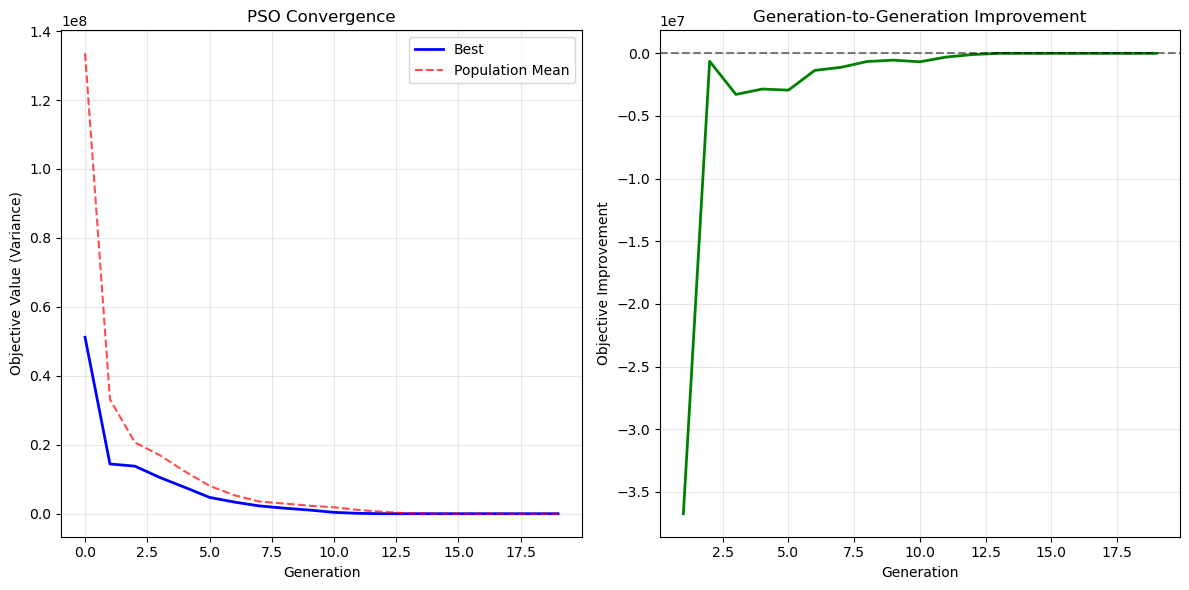


📈 CONVERGENCE STATISTICS:
   Initial objective: 51180962.242471
   Final objective: 18.314046
   Total improvement: -51180943.928425 (-100.00%)
   Recent improvement rate: -106676.45216716 per generation
   🏁 Algorithm appears to have converged (minimal recent progress)


In [11]:
# Plot convergence
history = result.optimization_history

if history:
    generations = [gen['generation'] for gen in history]
    best_objectives = [gen['best_objective'] for gen in history]
    mean_objectives = [gen['mean_objective'] for gen in history]
    
    plt.figure(figsize=(12, 6))
    
    # Plot convergence
    plt.subplot(1, 2, 1)
    plt.plot(generations, best_objectives, 'b-', label='Best', linewidth=2)
    plt.plot(generations, mean_objectives, 'r--', label='Population Mean', alpha=0.7)
    plt.xlabel('Generation')
    plt.ylabel('Objective Value (Variance)')
    plt.title('PSO Convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot improvement rate
    plt.subplot(1, 2, 2)
    if len(best_objectives) > 1:
        improvements = [best_objectives[i] - best_objectives[i-1] for i in range(1, len(best_objectives))]
        plt.plot(generations[1:], improvements, 'g-', linewidth=2)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Generation')
    plt.ylabel('Objective Improvement')  
    plt.title('Generation-to-Generation Improvement')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Convergence statistics
    final_improvement = best_objectives[-1] - best_objectives[0]
    print(f"\n📈 CONVERGENCE STATISTICS:")
    print(f"   Initial objective: {best_objectives[0]:.6f}")
    print(f"   Final objective: {best_objectives[-1]:.6f}")
    print(f"   Total improvement: {final_improvement:.6f} ({(final_improvement/best_objectives[0]*100):+.2f}%)")
    
    # Find when major improvements stopped
    if len(improvements) > 10:
        recent_improvements = improvements[-10:]
        avg_recent_improvement = np.mean(recent_improvements)
        print(f"   Recent improvement rate: {avg_recent_improvement:.8f} per generation")
        if abs(avg_recent_improvement) < abs(final_improvement) * 0.01:
            print("   🏁 Algorithm appears to have converged (minimal recent progress)")
        else:
            print("   🔄 Algorithm still making progress when terminated")


### Solution Visualization  

Visualize the spatial changes in service coverage.

=== SPATIAL COVERAGE VISUALIZATION ===
📊 Consistent color scale: 0 to 475.8 vehicles per zone


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu

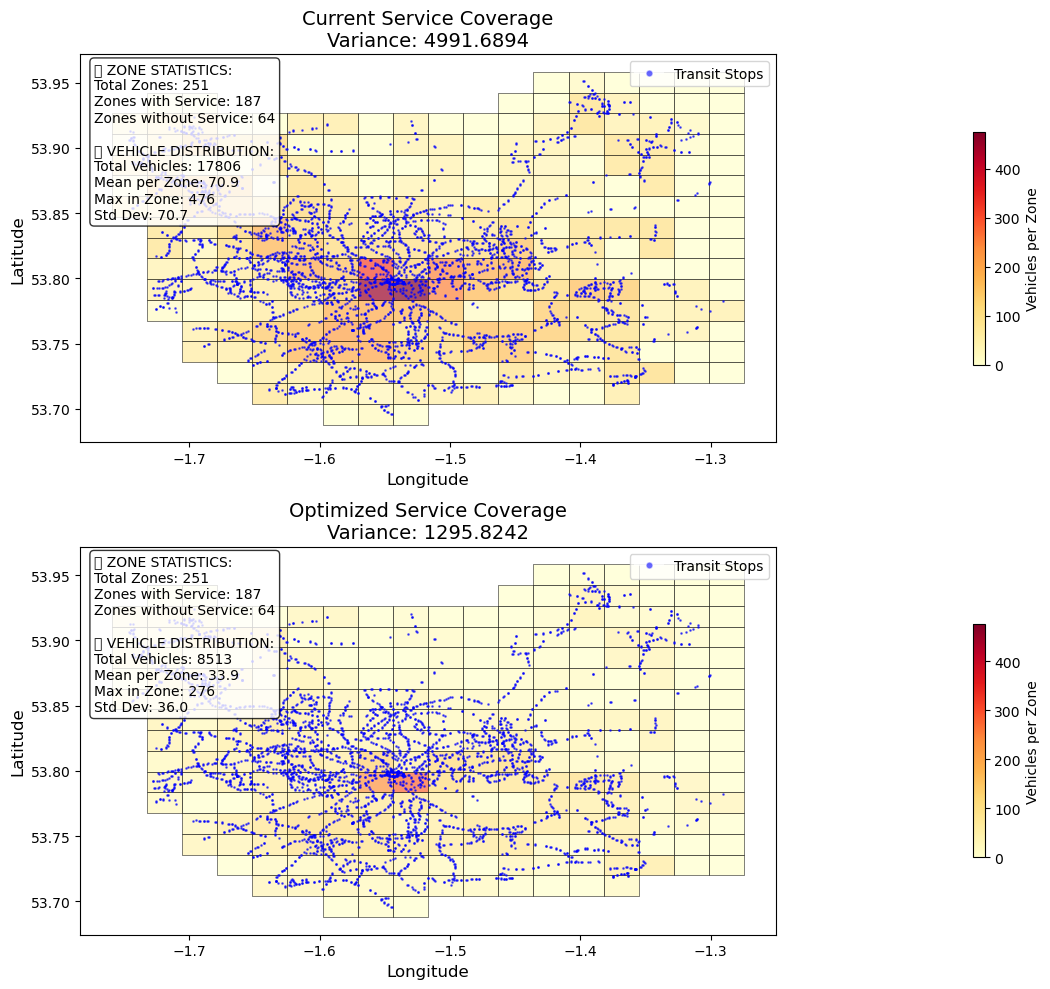

🎯 Spatial equity improvement: +74.0% reduction in coverage variance
🎨 Both maps use consistent scale: 0-475.8 vehicles per zone

✅ Single optimization analysis complete!


In [12]:
print("=== SPATIAL COVERAGE VISUALIZATION ===")

# Calculate consistent color scale for both maps
current_vehicles = coverage_objective.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'], opt_data
)["average"]

optimized_vehicles = coverage_objective.spatial_system._vehicles_per_zone(
    result.best_solution, opt_data
)["average"]

# Set consistent scale across both solutions
vmin = 0  # Start from zero for meaningful comparison
vmax = max(current_vehicles.max(), optimized_vehicles.max())

print(f"📊 Consistent color scale: 0 to {vmax:.1f} vehicles per zone")

# Visualize current vs optimized coverage with consistent scales
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Current solution
coverage_objective.spatial_system.visualize_spatial_coverage(
    solution_matrix=opt_data['initial_solution'],
    optimization_data=opt_data,
    figsize=None,  # Use subplot
    ax=axes[0],
    show_stops=True,
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title(f'Current Service Coverage\nVariance: {current_analysis["variance_average"]:.4f}', fontsize=14)

# Optimized solution  
coverage_objective.spatial_system.visualize_spatial_coverage(
    solution_matrix=result.best_solution,
    optimization_data=opt_data,
    figsize=None,  # Use subplot
    ax=axes[1], 
    show_stops=True,
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title(f'Optimized Service Coverage\nVariance: {solution_analysis["variance_average"]:.4f}', fontsize=14)

plt.tight_layout()
plt.show()

variance_improvement = ((current_analysis['variance_average'] - solution_analysis['variance_average']) / current_analysis['variance_average']) * 100
print(f"🎯 Spatial equity improvement: {variance_improvement:+.1f}% reduction in coverage variance")
print(f"🎨 Both maps use consistent scale: 0-{vmax:.1f} vehicles per zone")

print("\n✅ Single optimization analysis complete!")

# 2.3 Multi-Run Analysis

PSO is stochastic, and not guaranteed to find the global optimum in a single run. We saw above that it even struggles to find a solution that meets all constraints (specifically the FleetPerInterval constraint).

A multi-swarm approach can help because:
1. **Diverse Exploration**: Multiple swarms explore different areas of the solution space, reducing the chance of getting stuck in local optima.
2. **Information Sharing**: Swarms can share information about good solutions, accelerating convergence. TODO: This is not implemented yet.
3. **Robustness**: Running multiple swarms increases the likelihood of finding a feasible solution that meets all constraints.

In [17]:
# Configuration with FleetPerInterval constraint (the challenging one)
# 🔧 CONFIGURATION SELECTOR
USE_HARD_CONSTRAINTS = False  # Set to True for hard constraints, False for penalty method

# Base configuration shared by both approaches
base_config = {
    'problem': {
        'objective': {
            'type': 'HexagonalCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary_file': '../data/external/boundaries/study_area_boundary.geojson',
            'boundary_buffer_km': 2.0
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,  # 25% increase allowed
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.9,  # Maintain 70% of current service
                'level': 'system',
                'measure': 'peak', 
                'baseline': 'current_peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.4,  # increase per interval
                'allow_borrowing': False
            }
        ]
    },
    'optimization': {
        'termination': {
            'max_generations': 50
        },
        'monitoring': {
            'progress_frequency': 10,
            'save_history': True,
            'detailed_logging': True
        }
    }
}

# Hard constraints configuration
config_hard_constraints = {
    **base_config,
    'optimization': {
        **base_config['optimization'],
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False,  # HARD CONSTRAINTS
        }
    }
}

# Penalty method configuration
config_penalty_method = {
    **base_config,
    'problem': {
        **base_config['problem'],
        'penalty_weights': {
            'fleet_total': 5.0,
            'minimum_fleet': 5.0,
            'fleet_per_interval': 10.0  
        }
    },
    'optimization': {
        **base_config['optimization'],
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': True,   # PENALTY METHOD
            'penalty_weight': 10.0,
            'adaptive_penalty': False,
        }
    }
}

# Select configuration based on boolean
config_multi_swarm = config_hard_constraints if USE_HARD_CONSTRAINTS else config_penalty_method
method_name = "Hard Constraints" if USE_HARD_CONSTRAINTS else "Penalty Method"

print(f"\n🤖 SELECTED: {method_name}")
print(f"   Constraint handling: {'Direct rejection of infeasible solutions' if USE_HARD_CONSTRAINTS else 'Penalty-based exploration'}")


# Multi-run configuration
multi_run_config = {
    'n_runs': 5,  # Number of independent swarms
    'parallel': True,  # Set to True if you have multiple cores
    'comparison_metrics': ['best_objective', 'feasibility_rate', 'convergence_speed'],
    'save_all_histories': True
}

print(f"\n🎯 MULTI-SWARM CONFIGURATION:")
print(f"   Number of swarms: {multi_run_config['n_runs']}")
print(f"   Population per swarm: {config_multi_swarm['optimization']['algorithm']['pop_size']}")
print(f"   Total search agents: {multi_run_config['n_runs'] * config_multi_swarm['optimization']['algorithm']['pop_size']}")
print(f"   Generations per swarm: {config_multi_swarm['optimization']['termination']['max_generations']}")

n_intervals = opt_data['n_intervals']
total_constraints = 1 + n_intervals + 1  # FleetTotal + FleetPerInterval + Minimum
print(f"\n🔒 CONSTRAINT COMPLEXITY:")
print(f"   Total constraints: {total_constraints}")
# Access the list of constraints
constraints_list = config_multi_swarm['problem']['constraints']

print("--- Available Constraint Parameters ---")
# Loop through each constraint in the list
for constraint in constraints_list:
    constraint_type = constraint['type']
    # Check if 'tolerance' key exists
    if 'tolerance' in constraint:
        print(f"{constraint_type}, Tolerance: {constraint['tolerance']}") 
    # If not, check if 'min_fleet_fraction' key exists
    elif 'min_fleet_fraction' in constraint:
        print(f"{constraint_type}, Min Fleet Fraction: {constraint['min_fleet_fraction']}")

print(f"\n🚀 STARTING MULTI-SWARM OPTIMIZATION...")
print(f"This will run {multi_run_config['n_runs']} independent swarms and compare results...")

# Create config manager and runner
config_manager_multi = OptimizationConfigManager(config_dict=config_multi_swarm)
pso_runner_multi = PSORunner(config_manager_multi)

# Run multi-swarm optimization
multi_results = pso_runner_multi.optimize_multi_run(
    optimization_data=opt_data,
    num_runs=multi_run_config['n_runs'],
    parallel=multi_run_config['parallel']
)

print(f"\n✅ MULTI-SWARM OPTIMIZATION COMPLETED")
print(f"⏱️  Total time: {multi_results.total_time:.1f} seconds")
print(f"📊 Successful runs: {multi_results.num_runs_completed}")


🤖 SELECTED: Penalty Method
   Constraint handling: Penalty-based exploration

🎯 MULTI-SWARM CONFIGURATION:
   Number of swarms: 5
   Population per swarm: 35
   Total search agents: 175
   Generations per swarm: 50

🔒 CONSTRAINT COMPLEXITY:
   Total constraints: 6
--- Available Constraint Parameters ---
FleetTotalConstraintHandler, Tolerance: 0.25
MinimumFleetConstraintHandler, Min Fleet Fraction: 0.9
FleetPerIntervalConstraintHandler, Tolerance: 0.4

🚀 STARTING MULTI-SWARM OPTIMIZATION...
This will run 5 independent swarms and compare results...
📋 Using provided configuration dictionary
🔄 STARTING MULTI-RUN PSO OPTIMIZATION (5 runs)
   🚀 Parallel execution enabled
🚀 PARALLEL EXECUTION:
   👥 Using 5 parallel workers
   🔇 Individual run output suppressed for clarity
   📊 Progress will be shown as runs complete

📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
📋 Using provided configuration dictionary
📋 Using p

In [18]:
print("\n🔍 MULTI-SWARM RESULTS ANALYSIS:")

# Analyze results from all swarms
swarm_summaries = []
feasible_solutions = []

for i, result in enumerate(multi_results.all_results):
    violations = result.constraint_violations
    is_feasible = violations['feasible']
    
    summary = {
        'swarm': i + 1,
        'objective': result.best_objective,
        'feasible': is_feasible,
        'generations': result.generations_completed,
        'time': result.optimization_time,
        'total_violations': violations['total_violations'],
        'improvement_vs_baseline': ((current_objective_value - result.best_objective) / current_objective_value * 100)
    }
    
    swarm_summaries.append(summary)
    
    if is_feasible:
        feasible_solutions.append((i + 1, result))
    
    print(f"\n   Swarm {i+1}:")
    print(f"      Objective: {result.best_objective:.4f}")
    print(f"      Feasible: {'✅' if is_feasible else '❌'}")
    print(f"      Constraint violations: {violations['total_violations']}")
    print(f"      Improvement vs baseline: {summary['improvement_vs_baseline']:+.1f}%")
    print(f"      Generations: {result.generations_completed}")

# Find best solutions
if feasible_solutions:
    best_feasible = min(feasible_solutions, key=lambda x: x[1].best_objective)
    print(f"\n🏆 BEST FEASIBLE SOLUTION:")
    print(f"   Found by Swarm {best_feasible[0]}")
    print(f"   Objective: {best_feasible[1].best_objective:.4f}")
    print(f"   Improvement: {((current_objective_value - best_feasible[1].best_objective) / current_objective_value * 100):+.1f}%")
    
    # Analyze the best solution in detail
    best_result = best_feasible[1]
    best_analysis = coverage_objective.get_detailed_analysis(best_result.best_solution)
    
    print(f"\n📊 BEST SOLUTION DETAILED ANALYSIS:")
    print(f"   Variance reduction: {((current_analysis['variance_average'] - best_analysis['variance_average']) / current_analysis['variance_average'] * 100):+.1f}%")
    print(f"   Zones with service: {best_analysis['zones_with_service_average']} (vs {current_analysis['zones_with_service_average']} current)")
    print(f"   Mean vehicles per zone: {best_analysis['total_vehicles_average']:.1f} (vs {current_analysis['total_vehicles_average']:.1f} current)")
    
    # Check fleet requirements for best solution
    best_fleet_reqs = calculate_fleet_requirements(
        headways_matrix=best_result.best_solution,
        round_trip_times=opt_data['routes']['round_trip_times'],
        operational_buffer=operational_buffer,
        no_service_threshold=480.0,
        allowed_headways=opt_data['allowed_headways'],
        no_service_index=opt_data.get('no_service_index')
    )
    
    print(f"\n🚗 FLEET ANALYSIS (BEST SOLUTION):")
    print(f"   Peak fleet: {best_fleet_reqs['total_peak_fleet']} vehicles")
    print(f"   Fleet by interval: {best_fleet_reqs['fleet_per_interval'].tolist()}")
    print(f"   Peak fleet change: {((best_fleet_reqs['total_peak_fleet'] - current_fleet_reqs['total_peak_fleet']) / current_fleet_reqs['total_peak_fleet'] * 100):+.1f}%")
    
else:
    print(f"\n❌ NO FEASIBLE SOLUTIONS FOUND")
    print("   All swarms violated constraints")
    print("   Consider:")
    print("   • Increasing constraint tolerances")
    print("   • Using more swarms or generations")
    print("   • Adjusting penalty weights")
    
    # Show best infeasible solution
    best_infeasible = min(multi_results, key=lambda x: x.best_objective)
    best_swarm_idx = multi_results.index(best_infeasible) + 1
    print(f"\n🥈 BEST INFEASIBLE SOLUTION:")
    print(f"   Swarm {best_swarm_idx}")
    print(f"   Objective: {best_infeasible.best_objective:.4f}")
    print(f"   Improvement: {((current_objective_value - best_infeasible.best_objective) / current_objective_value * 100):+.1f}%")

# Compare swarm diversity
print(f"\n📈 SWARM DIVERSITY ANALYSIS:")
objectives = [s['objective'] for s in swarm_summaries]
feasibility_rate = sum(1 for s in swarm_summaries if s['feasible']) / len(swarm_summaries)

print(f"   Objective range: {min(objectives):.4f} to {max(objectives):.4f}")
print(f"   Objective std dev: {np.std(objectives):.4f}")
print(f"   Feasibility rate: {feasibility_rate:.1%}")


🔍 MULTI-SWARM RESULTS ANALYSIS:

   Swarm 1:
      Objective: 18.9247
      Feasible: ✅
      Constraint violations: 0
      Improvement vs baseline: +99.7%
      Generations: 50

   Swarm 2:
      Objective: 20.1888
      Feasible: ✅
      Constraint violations: 0
      Improvement vs baseline: +99.7%
      Generations: 50

   Swarm 3:
      Objective: 16.9423
      Feasible: ✅
      Constraint violations: 0
      Improvement vs baseline: +99.7%
      Generations: 50

   Swarm 4:
      Objective: 23.1839
      Feasible: ✅
      Constraint violations: 0
      Improvement vs baseline: +99.6%
      Generations: 50

   Swarm 5:
      Objective: 17.6699
      Feasible: ✅
      Constraint violations: 0
      Improvement vs baseline: +99.7%
      Generations: 50

🏆 BEST FEASIBLE SOLUTION:
   Found by Swarm 3
   Objective: 16.9423
   Improvement: +99.7%
📊 Spatial lag calculated:
   Input mean: 31.39
   Spatial lag mean: 31.88
   Non-zero lags: 244
📊 Spatial lag calculated (α=0.2):
   Mean di